# Usage example
This will become an usage example for the code. Recursion relations are tested here for now.

## I. Data structures
The code uses 2 types of new data structures: `ChiPhiFunc` and `ChiPhiEpsFunc` to represent
Fourier and power-Fourier series used in reference 1~3.

### I.1. ChiPhiFunc

`ChiPhiFunc` are objects representing functions of $\chi$ and $\phi$ that serves as power coefficient 
of near axis expansion terms. Each represents an even/odd Fourier series of form:
$$
F(\chi,\phi) = \sum_{m=0|1}^{n} A_m(\phi) e^{im\chi} + B_m(\phi) e^{-im\chi}
$$
where coefficients $A_m(\phi)$ and $B_m(\phi)$ are functions of $\phi$, with values sampled on grid points at $\phi=0, ... 2\pi(1-\frac{1}{\text{grid number}})$

`ChiPhiFunc`'s support `+, -, *, /` with other `ChiPhiFunc`'s or numpy constants. 
They also support $\frac{d}{d\chi}$, $\frac{d}{d\phi}$, $\int d\chi$, $\int^{\phi} d\phi'$ and some harmonic PDE solves. Still need to write documentations.

`ChiPhiFunc.display()` and `ChiPhiFunc.display_content()` inspects a `ChiPhiFunc`.

### I.2 ChiPhiEpsFunc

`ChiPhiEpsFunc` are list-like objects representing power series. Each constituent can be a numpy constant or `ChiPhiFunc`.

`ChiPhiEpsFunc.mask(n)` returns a new `ChiPhiEpsFunc` truncated to contain element 0 to n, but does not copy list constituents.
`ChiPhiEpsFunc.zero_append()` returns a new `ChiPhiEpsFunc` with a zero element added at the end. This is sometimes necessay
depending on the recursion relation being evaluated.

Accessing items out of boundary does not trigger errors. Instead, it returns `ChiPhiFuncNull`.
This feature is used internally during evaluation of recursion relations, but a recursion 
relation should not yield `ChiPhiFuncNull` 

Note: 
`ChiPhiFuncNull` is a special singleton case of `ChiPhiFunc` (`ChiPhiFunc`'s superclass). 
`ChiPhiFuncNull*0` returns 0, and all other combinations of arguments, algebraic operators and differentials returns itself. 

## II. Naming conventions
Except for the constant `dl_p`, all variables that are functions of $\epsilon$, $\chi$ and/or $\phi$ are terminated with a combination like `_coef`, `_cp` and `_coef_cp`. 


In [1]:
# This file implements and tests recursion relations
import numpy as np
import timeit
import scipy.signal
from matplotlib import pyplot as plt
from numba import jit, njit, prange
from numba import complex128, int64    # import jit value types
from functools import lru_cache # import functools for caching
import warnings

# for importing parsed codes
import sys
sys.path.insert(1,'/Users/lanke/Desktop/Second year project/Code/python_source/parsed/')
sys.path.insert(1,'/Users/lanke/Desktop/Second year project/Code/python_source/')
from chiphifunc import *
from math_utilities import *
from chiphiepsfunc import *
from chiphifunc_test_suite import *
debug_path = '/Users/lanke/Desktop/Second year project/Code/test_data_eduardo/'

Detected 16 CPU's. Setting n_jobs to #CPU/2.


Axis shape:


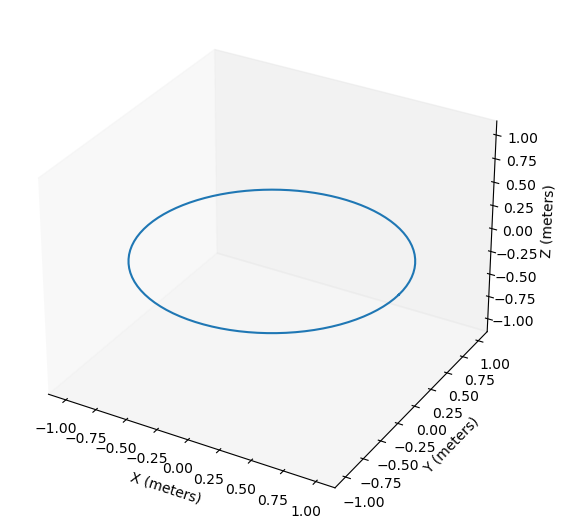

In [2]:
# No B theta
B_psi_coef_cp, B_theta_coef_cp, \
    Delta_coef_cp, p_perp_coef_cp,\
    X_coef_cp, Y_coef_cp, Z_coef_cp, \
    iota_coef, dl_p,\
    nfp, Xi_0, eta, \
    B_denom_coef_c, B_alpha_coef, \
    kap_p, tau_p = read_first_three_orders(
        debug_path+'circ/', 
        R_array=[2,0,1,2,0.0001,0],
        Z_array=[1,2,0,0.001]
    )

Axis shape:


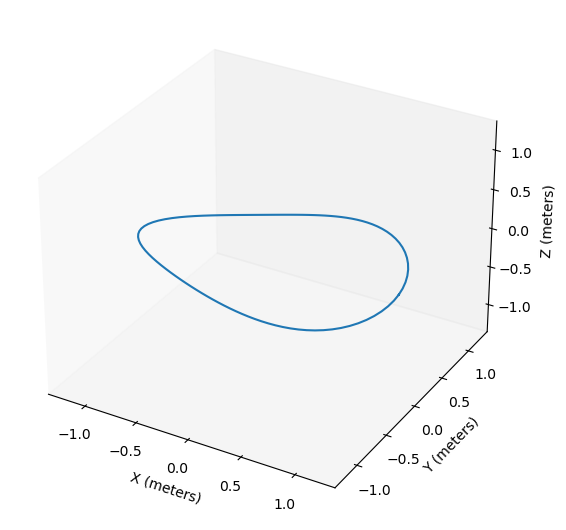

In [2]:
# No B theta
B_psi_coef_cp, B_theta_coef_cp, \
    Delta_coef_cp, p_perp_coef_cp,\
    X_coef_cp, Y_coef_cp, Z_coef_cp, \
    iota_coef, dl_p,\
    nfp, Xi_0, eta, \
    B_denom_coef_c, B_alpha_coef, \
    kap_p, tau_p = read_first_three_orders(
        debug_path+'5.2/', 
        R_array=[4,0,1,2,0.173,0,4,0.0168,0,6,0.00101,0],
        Z_array=[3,2,0,0.159,4,0,0.0165,6,0,0.000987]
    )
B_theta_coef_cp = B_theta_coef_cp.zero_append().zero_append()

Axis shape:


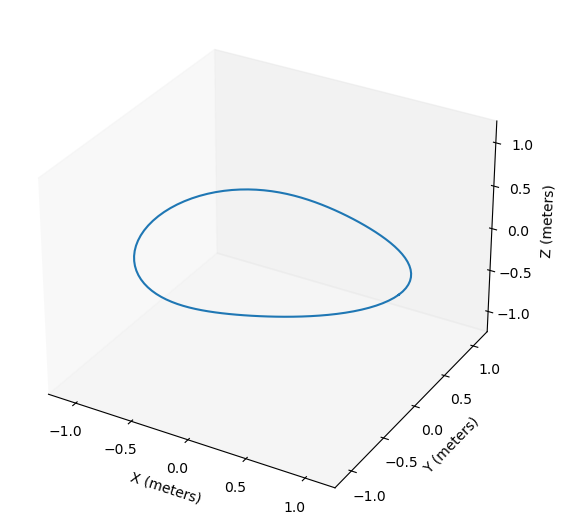

In [4]:
B_psi_coef_cp, B_theta_coef_cp, \
    Delta_coef_cp, p_perp_coef_cp,\
    X_coef_cp, Y_coef_cp, Z_coef_cp, \
    iota_coef, dl_p,\
    nfp, Xi_0, eta, \
    B_denom_coef_c, B_alpha_coef, \
    kap_p, tau_p = read_first_three_orders(
        debug_path+'5.3/', 
        R_array=[2,0,1,2,0.09,0],
        Z_array=[1,2,0,-0.09]
    )

Axis shape:


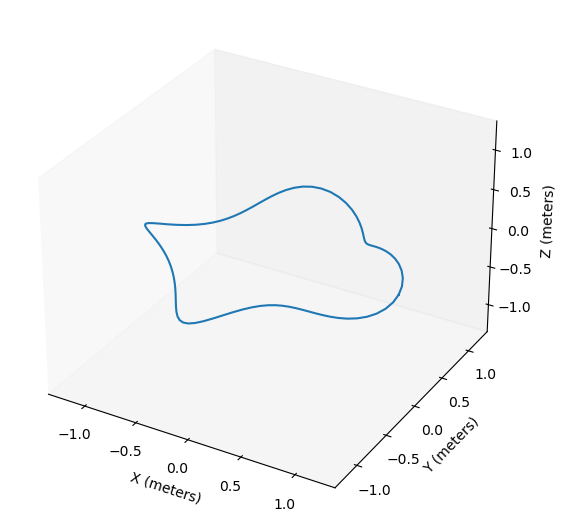

In [5]:
# No B theta
B_psi_coef_cp, B_theta_coef_cp, \
    Delta_coef_cp, p_perp_coef_cp,\
    X_coef_cp, Y_coef_cp, Z_coef_cp, \
    iota_coef, dl_p,\
    nfp, Xi_0, eta, \
    B_denom_coef_c, B_alpha_coef, \
    kap_p, tau_p = read_first_three_orders(
        debug_path+'5.4/', 
        R_array=[5,0,1,4,0.17,0,8,0.018191838304685660487880483060508,0,12,0.001420200653346571223467620370684,0,16,0.000059148767213264540889769427245426,0],
        Z_array=[5,0,0,4,0,0.15464423020448464507481389773602,8,0,0.017913837381820285621358834760031,12,0,0.0014893730073718687394179749361456,16,0,0.00006923943338841940945208031088498]
    )
B_theta_coef_cp = B_theta_coef_cp.zero_append()

Axis shape:


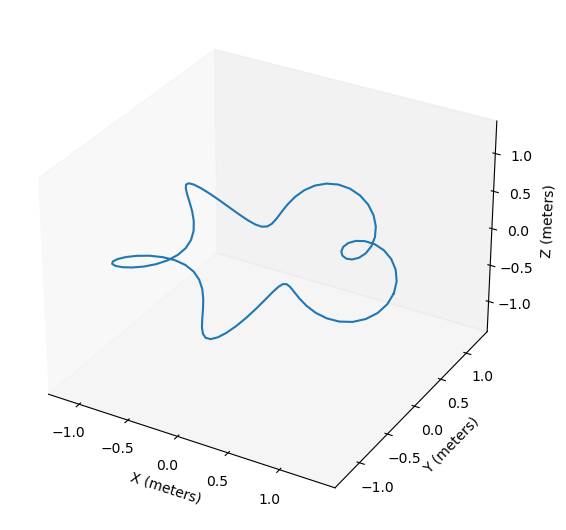

In [3]:
B_psi_coef_cp, B_theta_coef_cp, \
    Delta_coef_cp, p_perp_coef_cp,\
    X_coef_cp, Y_coef_cp, Z_coef_cp, \
    iota_coef, dl_p,\
    nfp, Xi_0, eta, \
    B_denom_coef_c, B_alpha_coef, \
    kap_p, tau_p = read_first_three_orders(
        debug_path+'5.5/', 
        R_array=[2,0,1,5,0.3,0],
        Z_array=[2,0,0,5,0,0.3]
    )

Issues:
1. Missing factor (dl/dp)?
2. 
3. pyqsc derivative: "pseudospectral" a higher order periodic diff scheme. "pseudospectral" 
4. Robert Dingo(?) Book on asymptotic error bounds (might be the series diverging)


## $X_n$

$X_n(\chi, \phi)$: Completely solved from $J^n$. Using $X_{n-1}, Y_{n-1}, Z_n, \iota_{\alpha (n-3)/2 \text{ or } (n-2)/2}, B_{\alpha (n-1)/2 \text{ or } n/2}$

In [7]:
import eval_xn

Difference


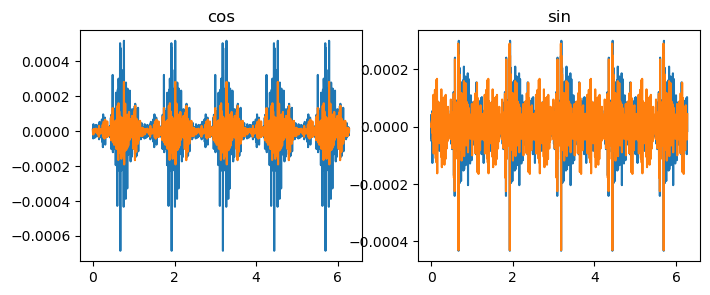

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            4.289e-06       3.305e-05      
Worst:          1.121e-03       3.424e-04      
Std             5.599e-05       4.292e-05      
Total imaginary component
0.0



/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  A_content_padded[a_pad_row:shape[0]-a_pad_row,a_pad_col:shape[1]-a_pad_col] = A.content
/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:97: ComplexWarning: Casting complex values to real discards the imaginary part
  B_content_padded[b_pad_row:shape[0]-b_pad_row,b_pad_col:shape[1]-b_pad_col] = B.content


In [8]:
n_eval = 3
Xn_test = eval_xn.eval_Xn_cp(
    n=n_eval,
    X_coef_cp=X_coef_cp.mask(n_eval-1).zero_append(), 
    Y_coef_cp=Y_coef_cp.mask(n_eval-1),
    Z_coef_cp=Z_coef_cp.mask(n_eval),
    B_denom_coef_c=B_denom_coef_c,
    B_alpha_coef=B_alpha_coef,
    kap_p=kap_p, dl_p=dl_p, tau_p=tau_p,
    iota_coef = iota_coef
)

compare_chiphifunc(Xn_test, X_coef_cp[n_eval])

## $Z_n$


$Z_{n+1}(\chi, \phi)$: Completely solved from $C_{\kappa, b, \tau}^n$. 

Requires $X_n, Y_n, Z_n$, 

$B_{\theta n+1}, B_{\psi n}$, 

$B_{\alpha (n-1)/2 \text{ or } (n-2)/2}$,

$\iota_{(n-1)/2 \text{ or } (n-2)/2} $

$\kappa, \frac{dl}{d\phi}, \tau$



$Z_{n}(\chi, \phi)$: Completely solved from $C_{\kappa, b, \tau}^n$. 

Requires $X_{n-1}, Y_{n-1}, Z_{n-1}$, 

$B_{\theta n}, B_{\psi n-1}$, 

$B_{\alpha (n-2)/2 \text{ or } (n-3)/2}$,

$\iota_{(n-2)/2 \text{ or } (n-3)/2} $

$\kappa, \frac{dl}{d\phi}, \tau$



In [9]:
import eval_znp1

In [10]:
# Only n=2 has sufficient data and is non-zero.
n_eval = 3
Zn_test = eval_znp1.eval_Zn_cp(
    n=n_eval,
    X_coef_cp=X_coef_cp.mask(n_eval-1),
    Y_coef_cp=Y_coef_cp.mask(n_eval-1),
    Z_coef_cp=Z_coef_cp.mask(n_eval-1).zero_append(),
    B_theta_coef_cp=B_theta_coef_cp,
    B_psi_coef_cp=B_psi_coef_cp.mask(n_eval-1),
    B_alpha_coef=B_alpha_coef,
    kap_p=kap_p, dl_p=dl_p, tau_p=tau_p,
    iota_coef = iota_coef
)


compare_chiphifunc(Zn_test, Z_coef_cp[n_eval])

/Users/lanke/Desktop/Second year project/Code/python_source/chiphiepsfunc.py:45: UserWarning: Mask size is larger than the list's size
  warnings.warn('Mask size is larger than the list\'s size')


TypeError: Cannot use get_shape() on ChiPhiFuncNull.

## $Y_{n+1}$ (OUTDATED. Please refer to recursion_relation.py)
Uses $X_{n+1}, Y_n, Z_n, B_{\theta n}, B_{\psi  n-2},
\iota_{(n-2)/2 \text{or} (n-3)/2}, B_{\alpha  n/2 \text{or} (n-1)/2}$

$Y_{n+1}$ is given by (conv(a) + conv(b)@dchi)@Yn+1 = RHS - LHS(Yn+1 = 0)

Under-determined solve is neeX_coef_cpded.

## $Y_{n}$
Uses $X_{n}, Y_{n-1}, Z_{n-1}, B_{\theta n-1}, B_{\psi  n-3},
\iota_{(n-3)/2 \text{or} (n-4)/2}, B_{\alpha  (n-1)/2 \text{or} (n-2)/2}$

In [6]:
import eval_ynp1

In [7]:
n_eval = 2

In [8]:
# This block solves for Yn using Yn+1 general formula. Just define a new method with 
# Y11s*sigma_tilde_n and n_eval inputs.

if n_eval%2==1:
    Yn1s_p, Yn1c_p = Y_coef_cp[n_eval].get_Yn1s_Yn1c()
    Y11s_p, Y11c_p = Y_coef_cp[1].get_Yn1s_Yn1c()

    # JUST FOR TESTING. ACTUAL IMPLEMENTATION IS
    # vai should be Yn1c = Y11s*sigma_tilde_n
    vai = Yn1c_p
else:
    vai = Y_coef_cp[n_eval].get_constant()

# Getting coeffs
# Both uses B_alpha0 and X1 only

coef_a = eval_ynp1.coef_a(n_eval-1, B_alpha_coef, X_coef_cp)
coef_b = eval_ynp1.coef_b(B_alpha_coef, X_coef_cp)

# Getting rhs-lhs
# for Yn to work, "n" must be subbed with n-1 here
ynp1_rhsmlhs = eval_ynp1.rhs_minus_lhs(n_eval-1,
    X_coef_cp,
    # Y_coef_cp.mask(n_eval) also works
    Y_coef_cp.mask(n_eval-1).zero_append(),
    Z_coef_cp,
    B_psi_coef_cp,
    B_theta_coef_cp,
    B_alpha_coef,
    kap_p, dl_p, tau_p,
    iota_coef)

# Solving (conv(a) + conv(b)@dchi)@Yn+1 = RHS - LHS(Yn+1 = 0) 
Yn_test = ChiPhiFunc.solve_A_B_dchi_y(chiphifunc_A=coef_a,
                                        chiphifunc_B=coef_b,
                                        chiphifunc_rhs=ynp1_rhsmlhs,
                                        rank_rhs=n_eval, # Yn has n+1 dof. So, RHS must have n dof.
                                        Yn_free=Yn_free)
compare_chiphifunc(Yn_test, Y_coef_cp[n_eval], simple_mode=False)

TypeError: ChiPhiFunc.solve_A_B_dchi_y() got an unexpected keyword argument 'v_source_A'

## $Y_{n1c}$ and $\bar{\iota}_{(n-1)/2}$ 

$\widetilde{\Lambda}_n$, uses $Y_{n-1}, \Xi_n(X_{n-1}, Z_{n}, \iota_{(n-3)/2})$

In [2]:
import eval_full_xi_n

Detected 16 CPU's. Setting n_jobs to #CPU/2.


NotDefinedError: Failed in nopython mode pipeline (step: analyzing bytecode)
The compiler failed to analyze the bytecode. Variable 'clip_n' is not defined.

File "../python_source/chiphifunc.py", line 1298:
def solve_degenerate_underdetermined_jit(A, v_rhs, i_free, vai, Y_mode=False):
    <source elided>
        raise ValueError("solve_underdetermined: A, v_rhs must have the same number of rows")
    A_einv = np.ascontiguousarray(inv_square_excluding_col_jit(A, i_free))[clip_n:-clip_n]
    ^


In [ ]:
# Testing if removing Yn and Zn+1 worked. 
n = 3
Z_coef_cp.mask(n+1)
print('suggested', eval_full_xi_n.eval_full_Xi_n_p(
        n, X_coef_cp, Y_coef_cp.mask(n-1).zero_append(), Z_coef_cp.mask(n).zero_append(), \
        kap_p, dl_p, tau_p, iota_coef).get_constant())
print('works', eval_full_xi_n.eval_full_Xi_n_p(
        n, X_coef_cp, Y_coef_cp.mask(n), Z_coef_cp.mask(n+1), \
        kap_p, dl_p, tau_p, iota_coef))

In [ ]:
# Must be evaluated with iota_{(n-1)/2} = 0 to get lambda_tilde
def Lambda_n_p(Yn1s_p, Y11s_p, Y11c_p, X11c_p, iota_0, tau_p, dl_p, sigma_p, Xi_n_p):
    return(
        Yn1s_p.dphi()*sigma_p/Y11s_p
        -2*iota_0*Yn1s_p/Y11s_p
        -Yn1s_p*Y11c_p.dphi()/(Y11s_p**2)
        +2*tau_p*dl_p*Yn1s_p*X11c_p/(Y11s_p**2)
        -2*Xi_n_p/(Y11s_p**2)
    )    

## $Y_{n1c}$ (or $\widetilde{\sigma}$). *UNTESTED.*
Uses $\Lambda_n (X_{n-1}, Y_{n-1}, Z_{n}, \iota_{(n-3)/2}), \widetilde{\sigma_{n}}(0), B_{\theta n+1}, B_0, B_{\alpha 0}$

In [ ]:
def sigma_tilde_n(sigma_tilde_n0,\
                  n, X_coef_cp, Y_coef_cp, Z_coef_cp,\
                  iota_coef,\
                  tau_p, dl_p, kap_p,\
                  B_denom_coef_c, B_alpha_coef, B_theta_coef_cp):
    
    Yn1s_p, Yn1c_p = Y_coef_cp[n].get_Yn1s_Yn1c()
    Y11s_p, Y11c_p = Y_coef_cp[1].get_Yn1s_Yn1c()
    _, X11c_p = X_coef_cp[1].get_Yn1s_Yn1c()
    
    # Note the difference with iota_nm1b2: iota(n-1)//2=0 is no longer applied here.
    Xi_n_p_no_iota_mask = eval_full_xi_n.eval_full_Xi_n_p(
        n, X_coef_cp, Y_coef_cp.mask(n-1).zero_append(), Z_coef_cp.mask(n).zero_append(), \
        kap_p, dl_p, tau_p, iota_coef).get_constant()
    
    iota_0 = iota_coef[0]
    
    sigma_p = Y11c_p/Y11s_p # Definition. On pg 4 below (6)
    Lambda_n_p_coefval = Lambda_n_p(Yn1s_p, Y11s_p, Y11c_p, Xi_n_p_no_iota_mask, iota_0, tau_p, dl_p, sigma_p, Xi_n_p)
    
    exponent = 2*iota_0*sigma_p.integrate_phi(periodic = False)
    exp_factor = exponent.exp()
    exp_factor_neg = (-exponent).exp()
    
    # B_0
    B0 = B_denom_coef_c[0]
    
    # B_{\alpha 0}
    B_alpha0 = B_alpha_coef[0]
    
    # B_{\theta n 0}. The whole term might be 0 depending on init conds (current free?)
    try:
        B_theta_np10 = B_theta_coef_cp[n+1].get_constant()
    except AttributeError:
        B_theta_np10 = B_theta_coef_cp[n+1]
    
    
    sigma_tilde_n = exp_factor_neg*(\
        sigma_tilde_n0\
        +(\
            exp_factor\
            *(Lambda_n_p_coefval+2*B_alpha0*B0*B_theta_np10/(Y11s_p**2))\
        ).integrate_phi(periodic=False)\
    )
    
    return(sigma_tilde_n)

## $\bar{\iota}_{(n-1)/2}$ 
Needs $\Lambda_n (X_{n-1}, Y_{n-1}, Z_{n}, \iota_{(n-3)/2}), B_{\theta n}, B_0, B_{\alpha 0}$ 

In [ ]:
# iota_{(n-1)/2}. 
def iota_nm1b2(n, X_coef_cp, Y_coef_cp, Z_coef_cp,\
               iota_coef,\
               tau_p, dl_p, kap_p,\
               B_denom_coef_c, B_alpha_coef, B_theta_coef_cp):
    
    if n%2!=1:
        raise ValueError("n must be even to evaluate iota_{(n-1)/2}")
    
    Yn1s_p, Yn1c_p = Y_coef_cp[n].get_Yn1s_Yn1c()
    Y11s_p, Y11c_p = Y_coef_cp[1].get_Yn1s_Yn1c()
    _, X11c_p = X_coef_cp[1].get_Yn1s_Yn1c()
    
    sigma_p = Y11c_p/Y11s_p # Definition. On pg 4 below (6)
    
    # Note: mask n leaves nth-order as the last order in. 
    # Xi requires Yn, Zn+1=0. This means mask(n-1) and mask(n)
    Xi_n_p = eval_full_xi_n.eval_full_Xi_n_p(
        n, X_coef_cp, Y_coef_cp.mask(n-1).zero_append(), Z_coef_cp.mask(n).zero_append(), \
        kap_p, dl_p, tau_p, iota_coef.mask((n-1)//2-1).zero_append()).get_constant()
    iota_0 = iota_coef[0]
    
    # Evaluates exp(2*iota_bar_0*integral_of_sigma_to_phi'). 
    exponent = 2*iota_0*sigma_p.integrate_phi(periodic = False)
    exp_factor = exponent.exp()
    exponent_2pi = 2*iota_0*sigma_p.integrate_phi(periodic = True)
    exp_factor_2pi = np.e**exponent_2pi
    
    # Defnition. On pg 4 above (8)
    sigma_n_tilde   = Yn1c_p/Y11s_p
    sigma_n_tilde_0 = sigma_n_tilde.get_phi_zero()

    # Yn1s_p MUST be evaluated with iota_nb2m1=0!
    Lambda_n_p_tilde = Lambda_n_p(Yn1s_p, Y11s_p, Y11c_p, X11c_p, iota_0, tau_p, dl_p, sigma_p, Xi_n_p)
    
    # B_0
    B0 = B_denom_coef_c[0]
    
    # B_{\alpha 0}
    B_alpha0 = B_alpha_coef[0]
    
    # B_{\theta n 0}. The whole term might be 0 depending on init conds (current free?)
    try:
        B_theta_n0 = B_theta_coef_cp[n].get_constant()
    except AttributeError:
        B_theta_n0 = B_theta_coef_cp[n]
    
    # The denominator,
    denom = (exp_factor*(1+sigma_p**2+(eta/kap_p)**4/4/B0)).integrate_phi(periodic = True)
    return(
        ((exp_factor*(Lambda_n_p_tilde+2*B_alpha0*B0*B_theta_n0/(Y11s_p**2))).integrate_phi(periodic = True)
        + sigma_n_tilde_0*(1-exp_factor_2pi))/denom
    )
    

In [ ]:
n_eval = 3
iota_test = iota_nm1b2(n_eval, 
           X_coef_cp, Y_coef_cp, Z_coef_cp, 
           iota_coef, 
           tau_p, dl_p, kap_p, 
           B_denom_coef_c, 
           B_alpha_coef, 
           B_theta_coef_cp)
print(iota_test)
print(iota_coef[1])

## $B_{\psi n-2}$
Uses $X_{n-1}, Y_{n-1}, Z_n,  B_{\theta n-1}, B_0, B_{\alpha 0}, \bar{\iota}_{(n-2)/2 \text{ or } (n-3)/2}$

In [ ]:
import eval_dchi_b_psi_nm2

In [ ]:
chiphifunc.diff_mode='finite_difference'
# Evaluating B_psi1 using D2&D3 and provided B_theta_3=0.
n_eval = 3
test_dchi_B_psi = eval_dchi_b_psi_nm2.eval_dchi_B_psi_cp_nm2(n_eval, \
    X_coef_cp, Y_coef_cp, Z_coef_cp.mask(n_eval-1).zero_append(), \
    B_theta_coef_cp, B_psi_coef_cp.mask(0).zero_append(), B_alpha_coef, B_denom_coef_c, \
    kap_p, dl_p, tau_p, iota_coef)
compare_chiphifunc(test_dchi_B_psi, B_psi_coef_cp[1].dchi())

In [ ]:
# Evaluating B_psi1 using D2&D3 and provided B_theta_3=0.
chiphifunc.diff_mode='fft'
n_eval = 3
test_dchi_B_psi = eval_dchi_b_psi_nm2.eval_dchi_B_psi_cp_nm2(n_eval, \
    X_coef_cp, Y_coef_cp, Z_coef_cp.mask(n_eval-1).zero_append(), \
    B_theta_coef_cp, B_psi_coef_cp.mask(0).zero_append(), B_alpha_coef, B_denom_coef_c, \
    kap_p, dl_p, tau_p, iota_coef)
compare_chiphifunc(test_dchi_B_psi, B_psi_coef_cp[1].dchi())

In [ ]:
# Evaluating B_psi1 using D2&D3 and provided B_theta_3=0.
chiphifunc.diff_mode='pseudo_spectral'
n_eval = 3
test_dchi_B_psi = eval_dchi_b_psi_nm2.eval_dchi_B_psi_cp_nm2(n_eval, \
    X_coef_cp, Y_coef_cp, Z_coef_cp.mask(n_eval-1).zero_append(), \
    B_theta_coef_cp, B_psi_coef_cp.mask(0).zero_append(), B_alpha_coef, B_denom_coef_c, \
    kap_p, dl_p, tau_p, iota_coef)
compare_chiphifunc(test_dchi_B_psi, B_psi_coef_cp[1].dchi())